In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR
import random

In [15]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Data Loading

In [16]:
df = pd.read_csv('data/ecommerce_customer_data_cleaned.csv')
df = df.iloc[:, 2:]
df

,Age,Gender,IncomeLevel,Country,City,TotalPurchases,AverageOrderValue,CustomerLifetimeValue,EmailEngagementRate,SocialMediaEngagementRate,...,PremiumMember,HasReturnedItems,FavoriteCategory_Beauty,FavoriteCategory_Books,FavoriteCategory_Clothing,FavoriteCategory_Electronics,FavoriteCategory_Food,FavoriteCategory_Home Goods,FavoriteCategory_Sports,FavoriteCategory_Toys
0,25,Prefer not to say,High,Japan,Tokyo,4,15.886509,327.828625,0.332365,0.379694,...,Yes,No,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0
1,38,Prefer not to say,High,United Kingdom,London,6,27.638853,181.725056,0.344574,0.140988,...,No,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.5
2,43,Prefer not to say,High,France,Paris,10,161.739425,1810.555150,0.409656,0.323660,...,No,Yes,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
3,49,Female,High,United States,Los Angeles,5,14.194263,86.219740,0.356765,0.268428,...,Yes,No,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0
4,29,Female,Very High,Japan,Tokyo,7,298.953396,2112.575945,0.222703,0.160427,...,No,No,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,39,Female,High,United States,New York,4,60.986389,212.992614,0.105934,0.128575,...,Yes,Yes,0.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0
9996,58,Prefer not to say,Low,Australia,Sydney,6,75.208556,549.352094,0.424127,0.298521,...,No,Yes,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0
9997,38,Other,Very High,United States,New York,1,37.196899,117.203509,0.487704,0.126018,...,No,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9998,29,Other,High,Germany,Berlin,3,13.191952,-6.655247,0.377627,0.600112,...,No,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
predict_column = 'CustomerLifetimeValue'
feature_columns = list(df.columns)
feature_columns.remove(predict_column)

# Model Training

In [18]:
X = df[feature_columns]
y = df[predict_column]

In [19]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3)

In [20]:
def clv_regression(X, y, seed=42):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in list(X.columns) if c not in num_cols]
    
    numeric_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('pca', PCA(n_components=0.95, random_state=seed))
    ])

    cat_pipeline = Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ], remainder='drop')

    model = LinearSVR(
        C=2.0, 
        max_iter=20000, 
        epsilon=0.01
    )

    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('regressor', model)
    ])

    pipe.fit(X, y)
    return pipe


In [21]:
model = clv_regression(X_train, y_train)
model

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Inference

In [22]:
y_pred = model.predict(X_test)

# Evaluation

## MAE

In [25]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

MAE: 188.43990260194533


## Plot

In [26]:
sorted_indecies = y_test.argsort()
y_test_sorted = y_test.iloc[sorted_indecies.values]
y_pred_sorted_by_test = y_pred[sorted_indecies.values]

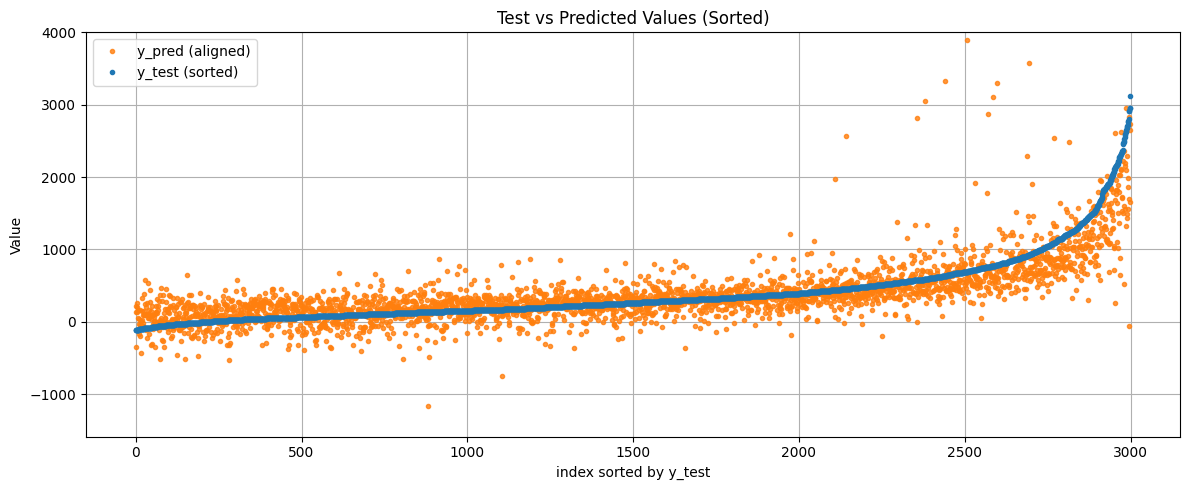

In [28]:
plt.figure(figsize=(12, 5))

# Use y_test_sorted as the X-axis
plt.plot(y_pred_sorted_by_test, label="y_pred (aligned)", alpha=0.8, linestyle='', marker = '.', color = 'tab:orange')
plt.plot(y_test_sorted.values, label="y_test (sorted)", linestyle='', marker = '.', color = 'tab:blue')

plt.xlabel("index sorted by y_test")
plt.ylabel("Value")
plt.title("Test vs Predicted Values (Sorted)")
plt.legend()
plt.grid(True)
plt.ylim(top=4000)
plt.tight_layout()
plt.show()